# Root Finding Lab

## Solving Kepler’s Equation for Planetary Orbits

In the early 17th century, Johannes Kepler used the precise observational data of Tycho Brahe to discover that planetary orbits are elliptical, not circular as previously believed.
Kepler distilled his findings into three laws of planetary motion.
The first two laws, relevant here, are:
1. Kepler's First Law: Each planet moves on an elliptical orbit with the Sun at one focus.
2. Kepler's Second Law: A line drawn from the planet to the Sun sweeps out equal areas in equal times.

To make practical predictions of a planet's position, Kepler introduced the concept of the mean anomaly $M$, the eccentric anomaly $E$, and the eccentricity $e$.
These parameters are related by Kepler's Equation:
\begin{align}
M = E - e \sin E,
\end{align}
where
* $M$ (Mean Anomaly):
  A linear measure of time, essentially $M = n (t - t_0)$, where $n$ is the mean motion (radians per unit time) and $t_0$ is the time of perihelion passage.
  $M$ increases uniformly with time.
* $E$ (Eccentric Anomaly):
  A geometrical angle related to the position of the planet on its elliptical orbit.
* $e$ (Eccentricity):
  A measure of how "elongated" the ellipse is.
  The value $e = 0$ corresponds to a perfect circle, whereas $0 < e < 1$ describes an ellipse, and $e \ge 1$ describes an unbound orbit (parabola or hyperbola, not covered in this lab).

Solving this transcendental equation $M = E - e \sin E$ for $E$ is crucial because, once you have $E$, you can compute the planet's position $(x, y)$ in its orbital plane via:
\begin{align}
x &= a (\cos E - e), \\
y &= a \sqrt{1 - e^2} \sin E.
\end{align}
where $a$ is the semi-major axis of the elliptical orbit.

Historically, Kepler struggled to invert $M = E - e \sin E$ analytically.
It does not have a simple closed-form solution.
Nonetheless, iterative methods—like the ones you will implement can find $E$ to any desired accuracy.
Similar breakthrough enabled astronomers to make precise predictions of planetary positions, confirming Kepler's model and revolutionizing astronomy.

For this lab, we want to predict the position of a planet at a given time $t$.
Specifically, given:
* The eccentricity of the planet's orbit, $e$.
* The semi-major axis of the orbit, $a$.
* The mean motion, $n$, which is $n = \sqrt{G(M_{\odot} + m)/a^3}$ in gravitational units (often simplified if the central mass is vastly larger than the planet's mass).
* The time of perihelion passage, $t_0$ (when the planet is closest to the Sun).
* A current time $t \geq t_0$.

Compute:
* Mean Anomaly: $M = n (t - t_0)$.
* Eccentric Anomaly: Solve Kepler's Equation.
* Position $(x, y)$ in orbital coordinates (where the ellipse is centered on the origin and the Sun is at one focus).

In practice, we need a numerical root-finding approach to solve $f(E) = E - e \sin E - M = 0$.

### Numerical Solvers

We can use Bisection Method, Secant Method, Newton-Raphson method.
For this alb, let's use Newton-Raphson method for fast convergence, but feel free to try other methods as well.

Recalling Newton-Raphson method:
\begin{align}
  x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}.
\end{align}

In [1]:
import numpy as np

# HANDSON: Implement Newton-Raphson method.

def newton(f, df, x0, tol=1e-6, imax=1000):
    for _ in range(imax):
        f0, df0 = f(x0), df(x0)
        if df0 == 0:
            raise ValueError("Derivative is zero. No convergence.")
        x = x0 - f0 / df0
        if abs(x - x0) < tol:
            return x
        x0 = x
    raise ValueError("Maximum iterations reached without convergence")

In [3]:
import jax
jax.config.update("jax_enable_x64", True)

from jax import grad
from jax import numpy as np

# HANDSON: Optional, implement Newton-Raphson method with autodiff

def autonewton(f, x0, tol=1e-6, imax=100):
    df = grad(f)
    for _ in range(imax):
        f0, df0 = f(x0), df(x0)
        if df0 == 0:
            raise ValueError("Derivative is zero. No convergence.")
        x = x0 - f0 / df0
        if abs(x - x0) < tol:
            return x
        x0 = x
    raise ValueError("Maximum iterations reached without convergence")

Next, we simply need to implement Kepler's equation, its derivative (optional if `autonewton()` is implemented), and the position formula.

In [9]:
# HANDSON: implement Kepler's equation, its derivative (if autonewton is not used), and
# the position equations

def kepler(E, M, e):
    """Function f(E) for Kepler's equation: f(E) = E - e*sin(E) - M."""
    f_E = E - e * np.sin(E) - M
    return f_E

def keplerp(E, e):
    """Derivative f'(E) = 1 - e*cos(E)."""
    fp = 1 - e * np.cos(E)
    return fp

def position(E, a, e):
    """ Return (x, y) coordinates of a planet in its orbital plane given
    eccentric anomaly E, semi-major axis a, and eccentricity e.
    """
    x = a * (np.cos(E) - e)
    y = a * (1 - e ** 2) ** .5 * np.sin(E)
    return x, y

With all functions defined, we can put it all together.
Here is a utility function that, given a time $t$, computes the planet's position:

In [10]:
# HANDSON: fill in the steps

def planet_position(t, t0, n, a, e, E0=0):
    """ Compute the position (x, y) of a planet at time t.

    t : Current time.
    t0: Time of perihelion passage.
    n : Mean motion, n = sqrt(G(M_sun+m)/a^3).
    a : Semi-major axis.
    e : Eccentricity (0 < e < 1).
    E0: Initial guess for E (eccentric anomaly).
    
    Returns:
        (x, y) : Coordinates of the planet in the orbital plane.
    """
    # 1. Compute mean anomaly
    M = n * (t - t0)

    # 2. Solve Kepler's equation for E
    f  = lambda E: kepler(E, M, e) # closure on M and e
    fp = lambda E: keplerp(E, e)   # closure on e
    E = newton(f, fp, E0, tol=1e-6, imax=100)
    
    # 3. Compute (x, y)
    return position(E, a, e)

### Example Usage: Earth-like Orbit

Let's do a simple example resembling Earth:
* Orbital period $P \approx 1$ year (for Earth, $\sim 365.25$ days).
* Mean motion: $n = 2\pi/P$.
  If we measure time in years, $n = 2\pi$.
* Semi-major axis: $a = 1$ AU (astronomical unit).
* Eccentricity: $e \approx 0.0167$ (very close to a circle).

In [11]:
# Earth-like parameters
t0 = 0.0       # Assume perihelion passage at time t=0
P  = 1.0       # Period of 1 year
n  = 2.0*np.pi # Mean motion
a  = 1.0       # Semi-major axis in AU
e  = 0.0167    # Eccentricity

# Generate times over one orbital period
times = np.linspace(0, P, 201)  # 200 points from 0 to 1 year

xs, ys = [], []
for t in times:
    x, y = planet_position(t, t0, n, a, e, E0=0.0)
    xs.append(x)
    ys.append(y)

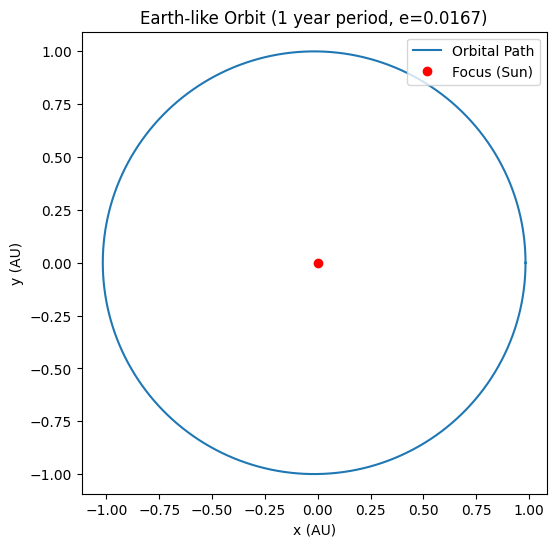

In [12]:
# Plot the orbit

from matplotlib import pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(xs, ys, label="Orbital Path")
plt.plot([0], [0], 'ro', label="Focus (Sun)")  # Place the Sun at the origin (slightly offset from center for elliptical orbits)
plt.axis("equal")
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.title("Earth-like Orbit (1 year period, e=0.0167)")
plt.legend(loc='upper right')

### Varying Eccentricity

Try the same code with a larger eccentricity (e.g., up to $e = 0.5$):

In [ ]:
# HANDSON: Try to change the eccentricities, what happen?
# If Newton-Raphson fails to converge, how may we fix it?

es = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

plt.figure(figsize=(6,6))

for e in es:
    xs, ys = [], []
    for t in times:
        x, y = planet_position(t, t0, n, a, e)
        xs.append(x)
        ys.append(y)
    plt.plot(xs, ys, label=f"e={e}")

plt.plot([0], [0], 'ro')  # The Sun
plt.axis("equal")
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.title("Effect of Eccentricity on Orbit Shape")
plt.legend(loc='upper right')

## Discussion:

Does the Newton-Raphson method always converge?
If not, how can we fix it?

`HANDSON: write your discussion here...`

## Summary

In this lab, you:
* Learned the historical and theoretical significance of Kepler's Equation in astronomy.
* Implemented a Newton-Raphson solver to handle the transcendental equation $M = E - e \sin E$.
* Produced orbital trajectories for different eccentricities, showcasing the geometry of elliptical orbits.
* Gained insight into how root-finding enables precise planetary position predictions—a cornerstone achievement of Kepler's work, which paved the way for modern celestial mechanics.